<a href="https://colab.research.google.com/github/hegdenischay/NEURONNet/blob/main/Automation/Synchrony_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References

References:

1) https://www.neuron.yale.edu/neuron/static/new_doc/programming/hocsyntax.html

2) https://www.neuron.yale.edu/neuron/static/new_doc/programming/python.html

3) https://www.neuron.yale.edu/neuron/static/py_doc/programming/python.html

4) https://www.geeksforgeeks.org/single-neuron-neural-network-python/

5) https://github.com/piazentin/ksets

6) AP - https://www.moleculardevices.com/applications/
patch-clamp-electrophysiology/what-action-potential#gref

7) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html

8) http://neupy.com/apidocs/neupy.algorithms.associative.hebb.html

9) https://qbi-software.github.io/NEURON-tutorial/lessons/network

10) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/topology/geometry.html

11) http://www.cnel.ufl.edu/courses/EEL6814/chapter6.pdf

12) https://www.slideshare.net/mentelibre/hebbian-learning

13) http://www.diva-portal.org/smash/get/diva2:1089220/FULLTEXT02

# Stage 1:Importing required libraries

In [1]:
pip install neuron

     |████████████████████████████████| 15.0 MB 5.2 MB/s 


In [2]:
import time
totalstart = time.time()
import os
if os.getcwd() != "/content":
    # we are not in google colab, assume hebbian library is in current dir
    from hebb import ORN, MCELL, GCELL
else:
    # download from git
    import shutil, requests
    url = 'https://cloud.operationtulip.com/s/t8nbn8Y582w94P3/download/git.zip'
    response = requests.get(url, stream=True)
    with open('git.zip', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    import zipfile
    with zipfile.ZipFile('git.zip', 'r') as zip_ref:
        zip_ref.extractall('')
    from hebb_test import ORN, MCELL, GCELL

In [3]:
from neuron import h                     #.h is a HOC object instanced & gui from neuron can also be imported 
from neuron.units import ms,mV
h.load_file('stdrun.hoc')                #Allows us to do a high level simulation
  
import matplotlib.pyplot as plt1

import numpy as np
from scipy.stats import poisson
import seaborn as sb

# from bokeh.io import output_notebook
# import bokeh.plotting as plt2
# output_notebook()



# Helper Functions

In [4]:
def stairstep(lo: float, hi: float, duration: int, max_duration: int = 200, noise: list = []) -> list:
    # duration and max_duration are in ms
    ans = [lo if i < duration else hi for i in range(0,max_duration)]
    if len(noise) == 0:
        return ans
    else:
        assert len(ans) == len(noise)
        return [ans[i]+noise[i] for i in range(len(ans))]
    # return [0+0.8*(i/duration) if i < duration else 0 for i in range(0,max_duration)]
    # visualize input 

In [5]:
def netConMaker(source, dest, weights, delay, threshold, place='axon', type='exc'):
    if place == 'axon':
        if type == 'exc':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendexcisyn, sec=source.axon)
        elif type == 'inh':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendinhisyn, sec=source.axon)
    elif place == 'soma':
        if type == 'exc':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendexcisyn, sec=source.soma)
        elif type == 'inh':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendinhisyn, sec=source.soma)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [6]:
def latConMaker(source, dest, weights, delay, threshold, type='exc'):
    if type == 'exc':
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendexcisyn, sec=source.dend)
    else:
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendinhisyn, sec=source.dend)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [7]:
def plotCell(source, name, addendum=''):
    recording_cell = source
    cell_axon = h.Vector().record(recording_cell.axon(0.5)._ref_v)
    cell_dend = h.Vector().record(recording_cell.dend(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    h.finitialize(-70 * mV)
    h.continuerun(300 * ms)

    f = plt1.figure(figsize=(16,9))
    ax = f.add_subplot(1,1,1)
    ax.plot(t, list(cell_axon), label=name+' axon '+addendum)
    ax.plot(t, list(cell_dend), label=name+' dendrite '+addendum)
    ax.legend(loc="upper right")
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('v (mV)')
    plt1.show()

In [8]:
import math
def generate_L_weight_delta(first, second):
    A_plus = 0.01
    A_minus = -0.011
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

In [9]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [10]:
#Gives one 2 coupled neuron using freeman's topology in olfactory bulb
class CONNECTING:

    def __init__(self,M,weights,delay1=1,delay2=1):
        wMM=weights[0]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 0
        
        #Making 2 neurons
        self.cells=[]
        self.P1=MCELL(1,self.M)
        self.P2=MCELL(2,self.M)
        self.cells.append(self.P1)
        self.cells.append(self.P2)
        
        #Giving current pulse
        if M != 1:
            self.stim = h.IClamp(self.P1.dend(0.5))
            self.stim.delay = 10
            self.stim.dur = 1000
            self.stim.amp = i1
            self.P1.dendexcisyn.tau = 1
            self.P1.dendinhisyn.tau = 4
            self.P2.dendexcisyn.tau = 1
            self.P2.dendinhisyn.tau = 4
            self.P1.axonexcisyn.tau = 1
            self.P1.axoninhisyn.tau = 4
            self.P2.axonexcisyn.tau = 1
            self.P2.axoninhisyn.tau = 4
        else:
            self.stim = h.IClamp(self.P1.dend(0.5))
            self.stim.delay = 10
            self.stim.dur = 1000
            self.stim.amp = i2
        
                
        #Connecting P1 to P2
        self.nc1 = h.NetCon(self.P1.axon(0.5)._ref_v,self.P2.dendexcisyn,sec=self.P1.axon)   # P1.axon to P2.dend
        # self.nc1.weight[0] = del1
        self.nc1.weight[0] = weight
        # print("mutual weight is ", weights[M])
        self.nc1.delay = 0.1 #tP1P2
        self.nc1.threshold = self.th
        
        #Connecting P2 to P1
        self.nc2 = h.NetCon(self.P2.axon(0.5)._ref_v,self.P1.dendexcisyn,sec=self.P2.axon)    #P2.axon to P1.dend
        # self.nc2.weight[0] = del2
        self.nc2.weight[0] = weight
        self.nc2.delay = 0.3 #tP2P1
        self.nc2.threshold = self.th    

            

**Stage 5: Laterally connect each set of 2 coupled neurons according to Freeman's KI Set**

In [11]:
class LATERAL:

    def __init__(self,N,weights):
        wMML=weights
        #wMML=0.1
        
        self.N = N
        self.th = -70
        self.maindelay = lateralDelay
        self.sets = []
        c=0
        for i in range(N):
            self.sets.append(CONNECTING(i,weights))
        
        self.netConArr = []
        # for r in range(0,N-1):
        #   #Connecting P1[0] to P1[1]
        #   # make a list for easier access
        #   netConList = []
        #   netConList.append(h.NetCon(self.sets[r].P1.axon(0.5)._ref_v, self.sets[r+1].P1.dendexcisyn,sec=self.sets[r].P1.axon))
        #   netConList[0].weight[0]  = wMML[r+N]
        # #   print("Lateral weight is", wMML[r+N])
        #   netConList[0].delay = delay1
        #   netConList[0].threshold = self.th

        #   netConList.append(h.NetCon(self.sets[r+1].P1.axon(0.5)._ref_v, self.sets[r].P1.dendexcisyn, sec=self.sets[r+1].P1.axon))
        #   netConList[1].weight[0] = wMML[r+N]
        #   netConList[1].delay = delay2
        #   netConList[1].threshold = self.th

        netConList = []
        netConList.append(h.NetCon(self.sets[0].P1.axon(0.5)._ref_v, self.sets[1].P1.dendexcisyn, sec=self.sets[0].P1.axon))
        netConList[0].weight[0] = del2
        netConList[0].delay = lateralDelay +1
        netConList[0].threshold = self.th
        netConList.append(h.NetCon(self.sets[1].P1.axon(0.5)._ref_v, self.sets[0].P1.dendexcisyn, sec=self.sets[1].P1.axon))
        netConList[1].weight[0] = del1
        netConList[1].delay = lateralDelay +1
        netConList[1].threshold = self.th
        self.netConArr.append(netConList)
        netConList = []
        netConList.append(h.NetCon(self.sets[1].P1.axon(0.5)._ref_v, self.sets[2].P1.dendexcisyn, sec=self.sets[1].P1.axon))
        netConList[0].weight[0] = del1
        netConList[0].delay = lateralDelay +1
        netConList[0].threshold = self.th
        netConList.append(h.NetCon(self.sets[2].P1.axon(0.5)._ref_v, self.sets[1].P1.dendexcisyn, sec=self.sets[2].P1.axon))
        netConList[1].weight[0] = del2
        netConList[1].delay = lateralDelay + 1
        netConList[1].threshold = self.th


        self.netConArr.append(netConList)


In [12]:
class LATERALNOCONN:

    def __init__(self,N,weights):
        wMML=weights
        #wMML=0.1
        
        self.N = N
        self.th = -70
        self.maindelay = lateralDelay
        self.sets = []
        c=0
        for i in range(N):
            self.sets.append(CONNECTING(i,weights))


**Stage 6: Input the number of 2 coupled sets required (which are all laterally connected)**

In [13]:
# #Give N value to get N no. of 2 coupled neurons laterally connected
# size = int(sets)
# given_input_from_user = size #  int(input('Enter the number of 2 coupled sets required: '))
# weights = np.random.uniform(0.5,1,15)
# # weights = [0.1 for i in range(15)]
# L1=LATERAL(given_input_from_user,weights)
# print(weights)

In [14]:
def learn():
    import sys, time
    tick = time.time()
    epochs = 30
    weight_data = []

    out = display(progress(0, epochs), display_id=True)

    for l in range(epochs):
        #print("iteration no is",l)
        out.update(progress(l, epochs))    
        # print("\nmutual learning")
        P1_axon_data = []
        P1_dend_data = []
        P2_axon_data = []
        P2_dend_data = []
        P1_spike_times = []
        P2_spike_times = []


        
        for i in range(len(L1.sets)):
            P1_axon_data.append(list(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)))
            P1_dend_data.append(list(h.Vector().record(L1.sets[i].P1.dend(0.5)._ref_v)))
            P1_spike_times.append(list(L1.sets[i].P1.spike_times))
            P2_axon_data.append(list(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v)))
            P2_spike_times.append(list(L1.sets[i].P2.spike_times))
            P2_dend_data.append(list(h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)))

        t = h.Vector().record(h._ref_t)
        h.finitialize(-70* mV)
        h.continuerun(300*ms)

        # h.finitialize(-70 * mV)

        for i in range(len(L1.sets)):
            # 2-coupled STDP-based learning
            L1.sets[i].nc1.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i])
            # logging
            # print("P1_axon", P1_spike_times[i], P2_spike_times[i])
            L1.sets[i].nc2.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i])
            
        # do a proper logging function
        weight_data.append(L1.sets[0].nc1.weight[0])
        # print(L1.sets[0].nc1.weight[0], L1.sets[0].nc2.weight[0])


        #Lateral Learning
        for i in range(len(L1.sets)-1):
            print(i)
            # 2-coupled part
            L1.netConArr[i][0].weight[0] += generate_L_weight_delta(P1_spike_times[i], P1_spike_times[i+1])
            L1.netConArr[i][1].weight[0] += generate_L_weight_delta(P1_spike_times[i+1], P1_spike_times[i])
        
        # plotCell(L1.sets[i].P1, 'P1')
    out.update(progress(epochs, epochs))    
    tock = time.time()
    # print("The time it took to learn", tock-tick, "seconds")

In [15]:
%matplotlib inline
def plotStuff():
    import numpy as np
    for i in range(sets):
        for j in range(1,3):
            exec(f"V{i}{j} = h.Vector().record(L1.sets[{i}].P{j}.axon(0.5)._ref_v)")
    h.finitialize(-70*mV)
    h.continuerun(300*ms)
    for i in range(sets):
        exec(f"V{i}Voltage = []", globals())
        for j in range(1,3):
            exec(f"V{i}Voltage.append(list(V{i}{j}))")
        exec(f"V{i}plot = np.mean(V{i}Voltage, axis=0)", globals())
    fig, axs = plt1.subplots(2, figsize=(16,9))
    axs[0].plot(V4plot, V0plot)
    axs[0].set_xlabel('V5 (V)')
    axs[0].set_ylabel('V1 (V)')
    axs[1].plot(V2plot, V1plot)
    axs[1].set_xlabel('V3 (V)')
    axs[1].set_ylabel('V2 (V)')
    plt1.show()

In [16]:
def printCov(i,j):
    arr1 = []
    arr2 = []
    import numpy as np
    arr1.append(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v))
    arr1.append(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v))
    arr2.append(h.Vector().record(L1.sets[j].P1.axon(0.5)._ref_v))
    arr2.append(h.Vector().record(L1.sets[j].P2.axon(0.5)._ref_v))
    h.finitialize(-70*mV)
    h.continuerun(300*ms)
    arr1Mean = np.mean(arr1, axis=0)
    arr2Mean = np.mean(arr2, axis=0)
    cov = np.cov(list(arr1Mean), list(arr2Mean))
    # print(cov[0][1]/(np.sqrt(cov[0][0]*cov[1][1])))
    return cov[0][1]/(np.sqrt(cov[0][0]*cov[1][1]))

# Output

# Covariance wrt delay

In [17]:
i1 = 0.22
i2 = 0.5
sets = 3
weights = np.random.uniform(0.5,1,15)
weight = 0.01
del1 = 4
del2 = 2

In [18]:
covListB = []
covListA = []
for i in range(5, 200, 5):
    lateralDelay = i
    extra = 1
    L1 = LATERAL(sets, weights)
    # print('delay = ', la, 'ms')
    # print('Covariance matrix:')
    covListB.append(printCov(0,1))
    covListB.append(printCov(0,2))

Lateral Delay: 195, del1: 4, del2: 2, i1: 0.22, i2: 0.5


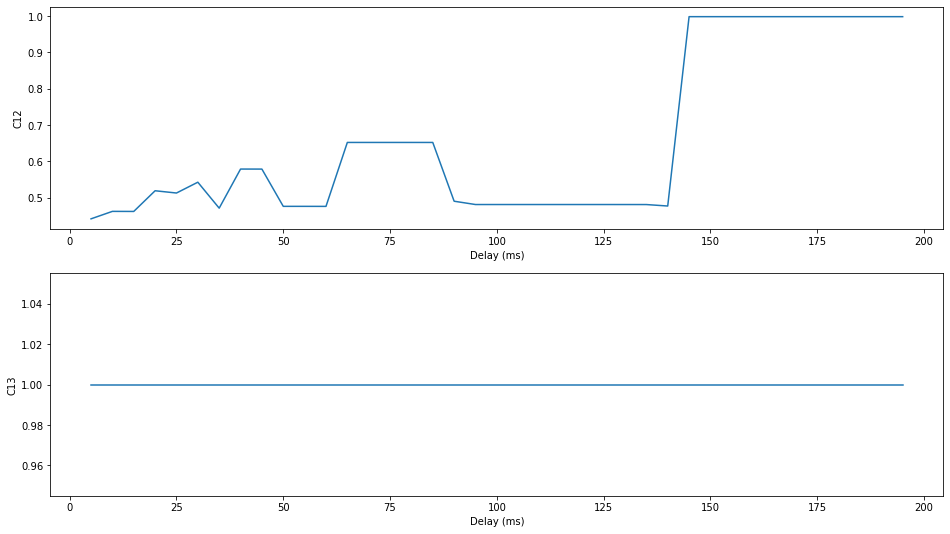

In [19]:
fig, axs = plt1.subplots(2, figsize=(16,9))
print(f"Lateral Delay: {lateralDelay}, del1: {del1}, del2: {del2}, i1: {i1}, i2: {i2}")
axs[0].plot([i for i in range(5,200,5)], covListB[::2])
axs[0].set_xlabel('Delay (ms)')
axs[0].set_ylabel('C12')
axs[1].plot([i for i in range(5,200,5)], covListB[1::2])
axs[1].set_xlabel('Delay (ms)')
axs[1].set_ylabel('C13')
plt1.show(fig)

# Plots wrt delay

In [20]:
# covariance
import pandas as pd
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [21]:
i1 = 0.8
i2 = 2
sets = 3
weights = np.random.uniform(0.5,1,15)
weight = 0.53
del1 = 4
del2 = 2
lateralDelay = 65

Lateral Delay: 65, del1: 4, del2: 2, i1: 0.8, i2: 2, skip: 1


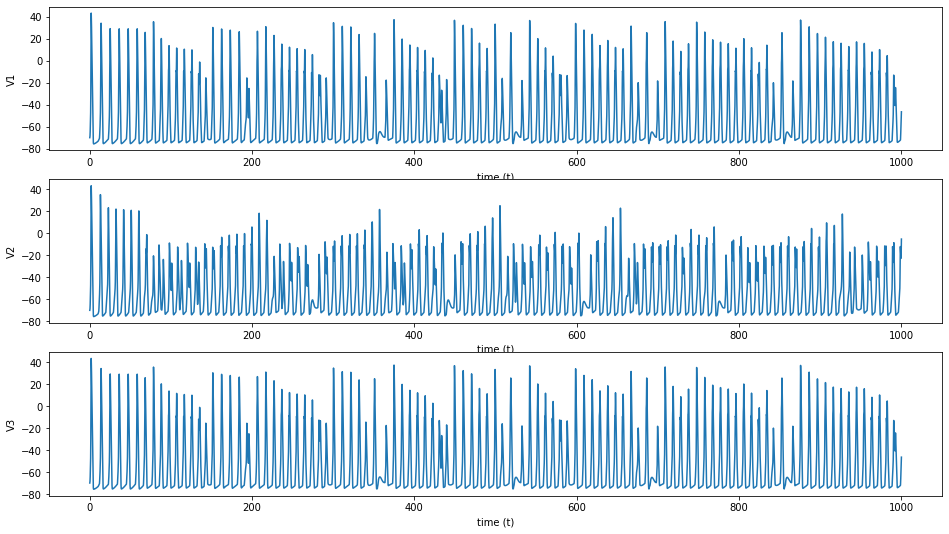

Length of V1 40001


No handles with labels found to put in legend.


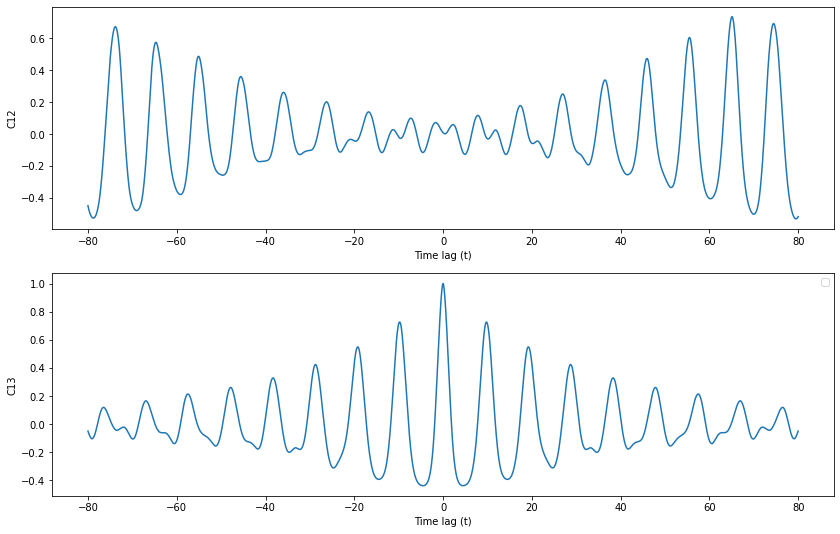

Lateral Delay: 65, del1: 4, del2: 2, i1: 0.8, i2: 2, skip: 6


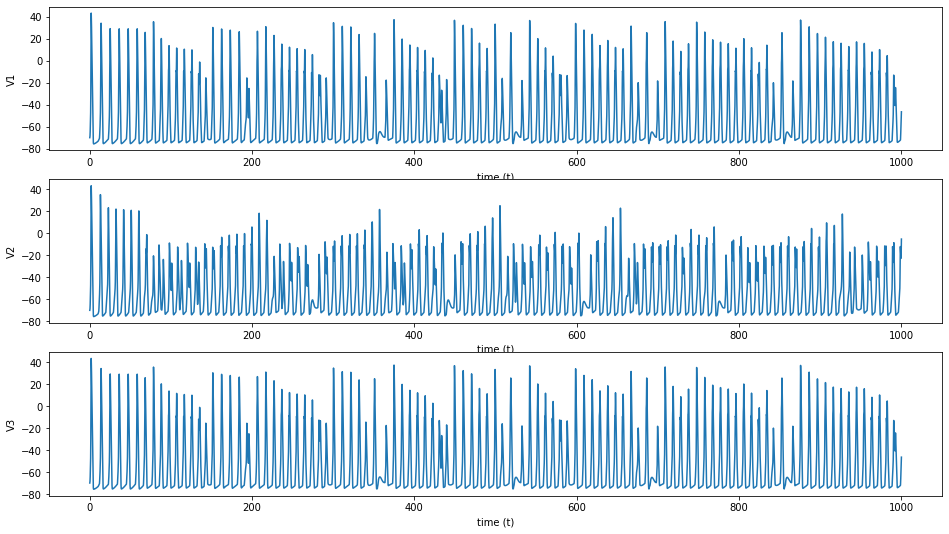

Length of V1 40001


No handles with labels found to put in legend.


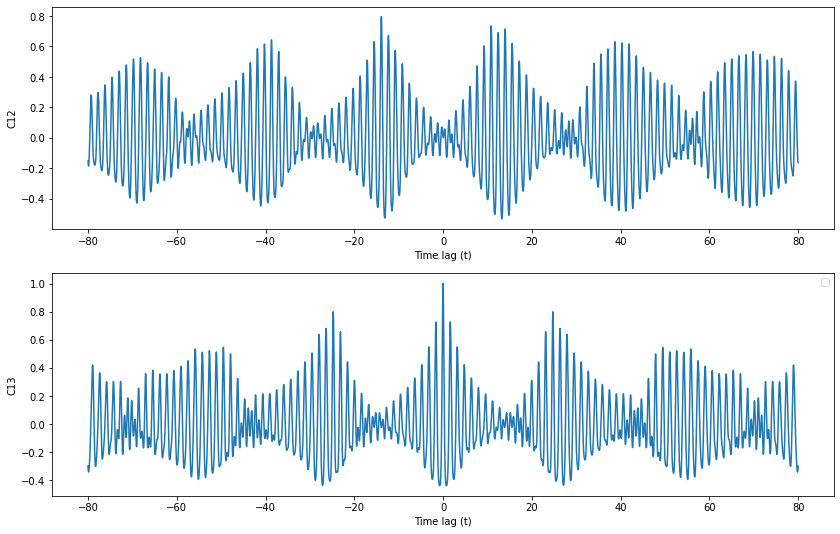

Lateral Delay: 65, del1: 4, del2: 2, i1: 0.8, i2: 2, skip: 11


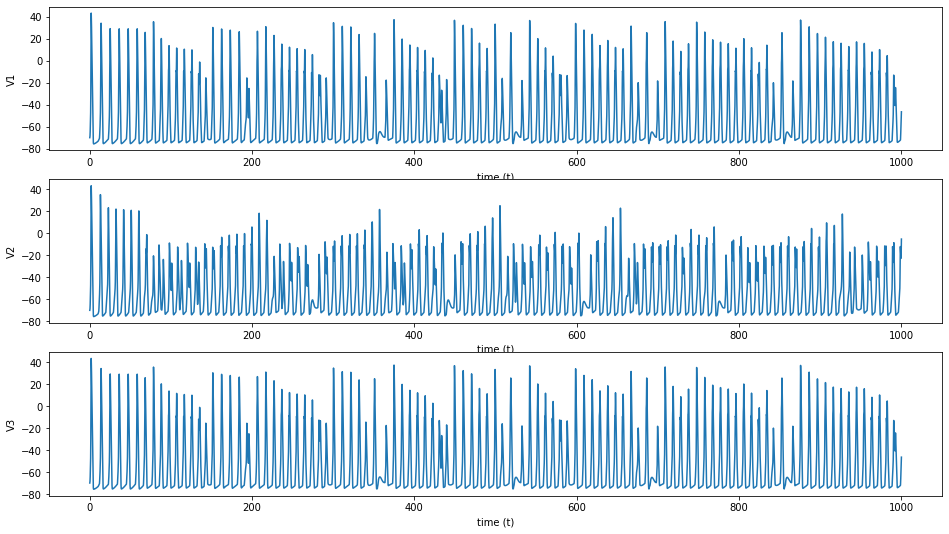

Length of V1 40001


No handles with labels found to put in legend.


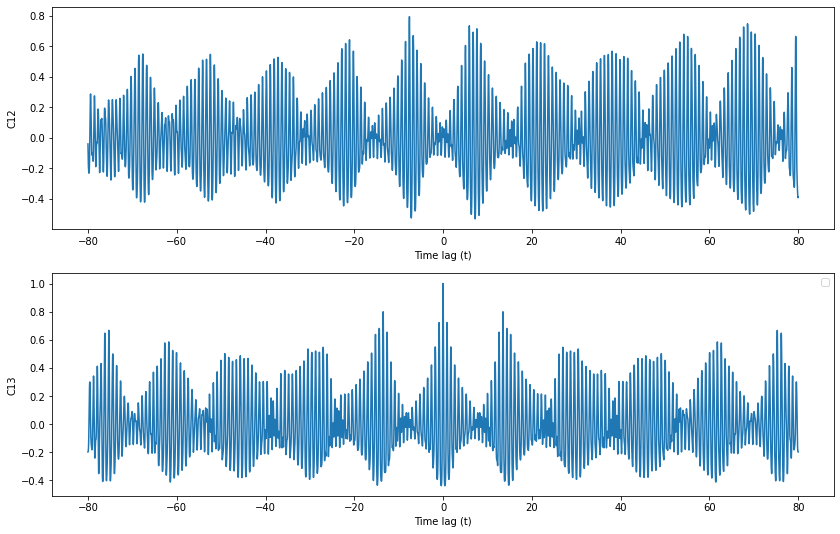

Lateral Delay: 65, del1: 4, del2: 2, i1: 0.8, i2: 2, skip: 16


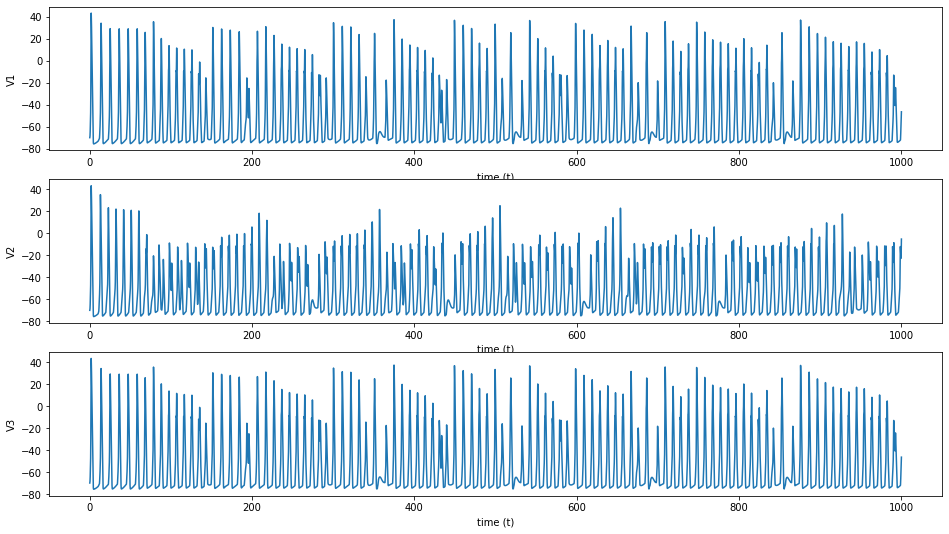

Length of V1 40001


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


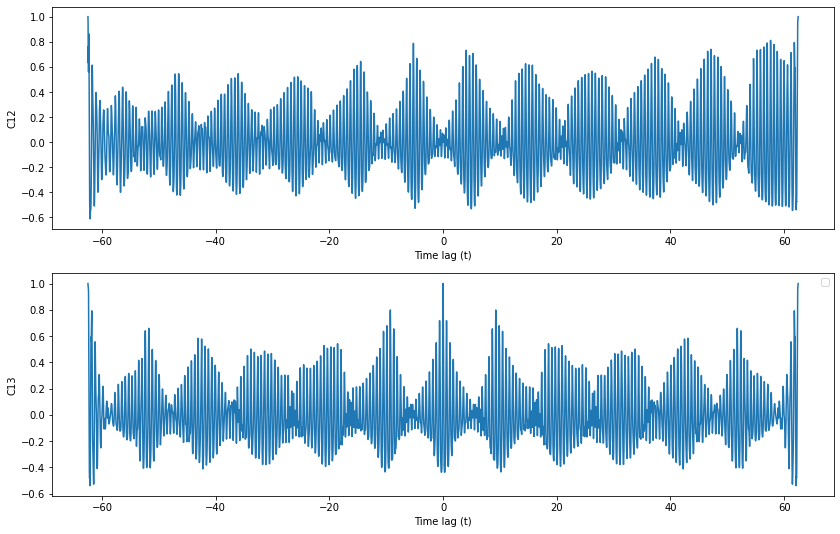

In [25]:
# FIGURE 4 DO NOT TOUCH
%matplotlib inline
for skip in range(1, 20, 5):
    L1 = LATERAL(sets, weights)
    print(f"Lateral Delay: {lateralDelay}, del1: {del1}, del2: {del2}, i1: {i1}, i2: {i2}, skip: {skip}")
    V1 , V2, V3 = [], [], []
    V1.append(h.Vector().record(L1.sets[0].P1.axon(0.5)._ref_v))
    V1.append(h.Vector().record(L1.sets[0].P2.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P1.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P2.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P1.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P2.axon(0.5)._ref_v))
    t = h.Vector().record(h._ref_t)
    h.finitialize(-70*mV)
    h.continuerun(1000*ms)
    V1Mean = np.mean(V1, axis=0)
    V2Mean = np.mean(V2, axis=0)
    V3Mean = np.mean(V3, axis=0)
    fig, axs = plt1.subplots(3, figsize=(16,9))
    axs[0].plot(t, list(V1Mean))
    axs[0].set_xlabel('time (t)')
    axs[0].set_ylabel('V1')
    axs[1].plot(t, list(V2Mean))
    axs[1].set_xlabel('time (t)')
    axs[1].set_ylabel('V2')
    axs[2].plot(t, list(V3Mean))
    axs[2].set_xlabel('time (t)')
    axs[2].set_ylabel('V3')
    plt1.show(fig)
    d1 = pd.DataFrame(V1Mean[::skip], columns=['voltage'])
    d2 = pd.DataFrame(V2Mean[::skip], columns=['voltage'])
    d3 = pd.DataFrame(V3Mean[::skip], columns=['voltage'])
    # print(d1,d2,d3)
    print("Length of V1",len(V1[0]))
    lim = int(80*len(V1[0])/1000)
    c12 = [crosscorr(d1['voltage'],d2['voltage'], lag) for lag in range(-int(lim),int(lim+1))]
    c13 = [crosscorr(d1['voltage'],d3['voltage'], lag) for lag in range(-int(lim),int(lim+1))]
    # ffset = np.floor(len(rs)/2)-np.argmax(rs)
    f,ax=plt1.subplots(2, figsize=(14,9))
    ax[0].plot([80*i/lim for i in range(-lim,lim+1)], c12)
    ax[0].set_xlabel('Time lag (t)')
    ax[0].set_ylabel('C12')
    ax[1].plot([80*i/lim for i in range(-lim,lim+1)], c13)
    ax[1].set_xlabel('Time lag (t)')
    ax[1].set_ylabel('C13')
    # ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
    # ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
    # ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
    # ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
    plt1.legend()
    plt1.show()

# brute forcing to figure out fig 4

In [ ]:
weights = [0.5, 0.5, 0.5]
lateralDelay = 45
for del2 in np.arange(0.1,2.1,0.1).round(2):
    for del1 in np.arange(0.1, 2.1, 0.1).round(2):
        for i1 in np.arange(0.2, 0.9, 0.1).round(2):
            L1 = LATERAL(sets, weights)
            V1 , V2, V3 = [], [], []
            V1.append(h.Vector().record(L1.sets[0].P1.axon(0.5)._ref_v))
            V1.append(h.Vector().record(L1.sets[0].P2.axon(0.5)._ref_v))
            V2.append(h.Vector().record(L1.sets[1].P1.axon(0.5)._ref_v))
            V2.append(h.Vector().record(L1.sets[1].P2.axon(0.5)._ref_v))
            V3.append(h.Vector().record(L1.sets[2].P1.axon(0.5)._ref_v))
            V3.append(h.Vector().record(L1.sets[2].P2.axon(0.5)._ref_v))
            t = h.Vector().record(h._ref_t)
            h.finitialize(-70*mV)
            h.continuerun(1000*ms)
            V1Mean = np.mean(V1, axis=0)
            V2Mean = np.mean(V2, axis=0)
            V3Mean = np.mean(V3, axis=0)
            # print(len(L1.sets[0].P1.spike_times), len(L1.sets[1].P1.spike_times))
            if len(L1.sets[0].P1.spike_times) == len(L1.sets[1].P1.spike_times):
                print(f"Lateral Delay: {lateralDelay}, del1: {del1}, del2: {del2}, i1: {i1}, i2: {i2}")
            elif list(L1.sets[0].P1.spike_times) == list(L1.sets[1].P1.spike_times):
                fig, axs = plt1.subplots(3, figsize=(16,9))
                axs[0].plot(t, list(V1Mean))
                axs[0].set_xlabel('time (t)')
                axs[0].set_ylabel('V1')
                axs[1].plot(t, list(V2Mean))
                axs[1].set_xlabel('time (t)')
                axs[1].set_ylabel('V2')
                axs[2].plot(t, list(V3Mean))
                axs[2].set_xlabel('time (t)')
                axs[2].set_ylabel('V3')
                plt1.show(fig)

# Figure 5: Connections without coupling

In [ ]:
# for i2 = 2, it looks like these plots give a 1:2 periodicity at weight > 0.53
# this required to extend all inputs to 1000ms
# why does wikipedia say that HH neurons go from 5 to 12 nAmp
i1 = 2
i2 = 4
sets = 3
weights = np.random.uniform(0.05,0.1,15)
weight = 0.01
del1 = 4
del2 = 2
lateralDelay = 65

In [ ]:
#without coupling
weights = [0.5, 0.5, 0.5]
for weight in np.arange(0.01, 0.06, 0.01).round(2):
    L1 = LATERALNOCONN(sets, weights)
    print(f"Lateral Delay: {lateralDelay}, del1: {del1}, del2: {del2}, i1: {i1}, i2: {i2}, weight:{weight}")
    V1 , V2, V3 = [], [], []
    V1.append(h.Vector().record(L1.sets[0].P1.axon(0.5)._ref_v))
    V1.append(h.Vector().record(L1.sets[0].P2.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P1.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P2.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P1.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P2.axon(0.5)._ref_v))
    t = h.Vector().record(h._ref_t)
    h.finitialize(-70*mV)
    h.continuerun(1000*ms)
    V1Mean = np.mean(V1, axis=0)
    V2Mean = np.mean(V2, axis=0)
    V3Mean = np.mean(V3, axis=0)
    fig, axs = plt1.subplots(3, figsize=(16,9))
    axs[0].plot(t, list(V1Mean))
    axs[0].set_xlabel('time (t)')
    axs[0].set_ylabel('V1')
    axs[1].plot(t, list(V2Mean))
    axs[1].set_xlabel('time (t)')
    axs[1].set_ylabel('V2')
    axs[2].plot(t, list(V3Mean))
    axs[2].set_xlabel('time (t)')
    axs[2].set_ylabel('V3')
    plt1.show(fig)
    fig, axs = plt1.subplots(2, figsize=(16,9))
    axs[0].plot(list(V1Mean), list(V2Mean))
    axs[0].set_xlabel('V1 (mV)')
    axs[0].set_ylabel('V2 (mV)')
    axs[1].plot(list(V1Mean), list(V3Mean))
    axs[1].set_xlabel('V1 (mV)')
    axs[1].set_ylabel('V3 (mV)')
    plt1.show(fig)

In [ ]:
#with coupling
weights = [0.5, 0.5, 0.5]
for weight in np.arange(0.01, 0.06, 0.01).round(2):
    L1 = LATERAL(sets, weights)
    print(f"Lateral Delay: {lateralDelay}, del1: {del1}, del2: {del2}, i1: {i1}, i2: {i2}, weight:{weight}")
    V1 , V2, V3 = [], [], []
    V1.append(h.Vector().record(L1.sets[0].P1.axon(0.5)._ref_v))
    V1.append(h.Vector().record(L1.sets[0].P2.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P1.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P2.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P1.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P2.axon(0.5)._ref_v))
    t = h.Vector().record(h._ref_t)
    h.finitialize(-70*mV)
    h.continuerun(1000*ms)
    V1Mean = np.mean(V1, axis=0)
    V2Mean = np.mean(V2, axis=0)
    V3Mean = np.mean(V3, axis=0)
    fig, axs = plt1.subplots(3, figsize=(16,9))
    axs[0].plot(t, list(V1Mean))
    axs[0].set_xlabel('time (t)')
    axs[0].set_ylabel('V1')
    axs[1].plot(t, list(V2Mean))
    axs[1].set_xlabel('time (t)')
    axs[1].set_ylabel('V2')
    axs[2].plot(t, list(V3Mean))
    axs[2].set_xlabel('time (t)')
    axs[2].set_ylabel('V3')
    plt1.show(fig)
    h.finitialize(-70*mV)
    h.continuerun(1000*ms)
    V1Mean = np.mean(V1, axis=0)
    V2Mean = np.mean(V2, axis=0)
    V3Mean = np.mean(V3, axis=0)
    fig, axs = plt1.subplots(2, figsize=(16,9))
    axs[0].plot(list(V1Mean), list(V2Mean))
    axs[0].set_xlabel('V1')
    axs[0].set_ylabel('V2')
    axs[1].plot(list(V1Mean), list(V3Mean))
    axs[1].set_xlabel('V1')
    axs[1].set_ylabel('V3')
    plt1.show(fig)

In [ ]:
i1 = 0.22
i2 = 0.5
sets = 3
weights = np.random.uniform(0.5,1,15)
weight = 0.01
del1 = 4
del2 = 2

In [ ]:
# covariance
import pandas as pd
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

lateralDelay = 50
for skip in range(5, 200, 5):
    L1 = LATERAL(sets, weights)
    print(f"Lateral Delay: {lateralDelay}, del1: {del1}, del2: {del2}, i1: {i1}, i2: {i2}, skip: {skip}")
    V1 , V2, V3 = [], [], []
    V1.append(h.Vector().record(L1.sets[0].P1.axon(0.5)._ref_v))
    V1.append(h.Vector().record(L1.sets[0].P2.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P1.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P2.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P1.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P2.axon(0.5)._ref_v))
    t = h.Vector().record(h._ref_t)
    h.finitialize(-70*mV)
    h.continuerun(1000*ms)
    V1Mean = np.mean(V1, axis=0)
    V2Mean = np.mean(V2, axis=0)
    V3Mean = np.mean(V3, axis=0)
    d1 = pd.DataFrame(V1Mean[::skip], columns=['voltage'])
    d2 = pd.DataFrame(V2Mean[::skip], columns=['voltage'])
    d3 = pd.DataFrame(V3Mean[::skip], columns=['voltage'])
    # print(d1,d2,d3)
    lim = 80
    c12 = [crosscorr(d1['voltage'],d2['voltage'], lag) for lag in range(-int(lim),int(lim+1))]
    c13 = [crosscorr(d1['voltage'],d3['voltage'], lag) for lag in range(-int(lim),int(lim+1))]
    # ffset = np.floor(len(rs)/2)-np.argmax(rs)
    f,ax=plt1.subplots(2, figsize=(14,9))
    ax[0].plot([i for i in range(-lim,lim+1)], c12)
    ax[1].plot([i for i in range(-lim,lim+1)], c13)
    # ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
    # ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
    # ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
    # ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
    plt1.legend()
    plt1.show()

In [ ]:
import numpy as np
arr1 = []
arr3 = []
L1 = LATERAL(sets, weights)
arr1.append(h.Vector().record(L1.sets[0].P1.axon(0.5)._ref_v))
arr1.append(h.Vector().record(L1.sets[0].P2.axon(0.5)._ref_v))
arr3.append(h.Vector().record(L1.sets[2].P1.axon(0.5)._ref_v))
arr3.append(h.Vector().record(L1.sets[2].P2.axon(0.5)._ref_v))
h.finitialize(-70*mV)
h.continuerun(300*ms)
arr1Mean = np.mean(list(arr1), axis=0)
arr3Mean = np.mean(list(arr3), axis=0)
print(arr1Mean, arr3Mean)
plt1.plot(arr1Mean, arr3Mean)

In [ ]:
%matplotlib inline
import numpy as np
weights = [0.5, 0.3, 0.5]
for i in np.arange(0.1,2,0.1).round(2):
    for j in np.arange(0.1,2,0.1).round(2):
        lateralDelay = 50
        del2 = i
        del1 = j
        print(f"del2 is {i}, del1 is {j}")
        L1 = LATERAL(sets, weights)
        V1 , V2, V3 = [], [], []
        V1.append(h.Vector().record(L1.sets[0].P1.axon(0.5)._ref_v))
        V1.append(h.Vector().record(L1.sets[0].P2.axon(0.5)._ref_v))
        V2.append(h.Vector().record(L1.sets[1].P1.axon(0.5)._ref_v))
        V2.append(h.Vector().record(L1.sets[1].P2.axon(0.5)._ref_v))
        V3.append(h.Vector().record(L1.sets[2].P1.axon(0.5)._ref_v))
        V3.append(h.Vector().record(L1.sets[2].P2.axon(0.5)._ref_v))
        t = h.Vector().record(h._ref_t)
        h.finitialize(-70*mV)
        h.continuerun(1000*ms)
        V1Mean = np.mean(V1, axis=0)
        V2Mean = np.mean(V2, axis=0)
        V3Mean = np.mean(V3, axis=0)
        fig, axs = plt1.subplots(3, figsize=(16,9))
        axs[0].plot(t, list(V1Mean))
        axs[0].set_xlabel('time (t)')
        axs[0].set_ylabel('V1')
        axs[1].plot(t, list(V2Mean))
        axs[1].set_xlabel('time (t)')
        axs[1].set_ylabel('V2')
        axs[2].plot(t, list(V3Mean))
        axs[2].set_xlabel('time (t)')
        axs[2].set_ylabel('V3')
        plt1.show(fig)

In [ ]:
%matplotlib inline
import numpy as np
weights = [0.5, 0.3, 0.5]
for i in np.arange(1,20,1):
    for j in np.arange(1,20,1).round(2):
        del2 = i
        del1 = j
        print(f"del2 is {i}, del1 is {j}")
        L1 = LATERAL(sets, weights)
        V1 , V2, V3 = [], [], []
        V1.append(h.Vector().record(L1.sets[0].P1.axon(0.5)._ref_v))
        V1.append(h.Vector().record(L1.sets[0].P2.axon(0.5)._ref_v))
        V2.append(h.Vector().record(L1.sets[1].P1.axon(0.5)._ref_v))
        V2.append(h.Vector().record(L1.sets[1].P2.axon(0.5)._ref_v))
        V3.append(h.Vector().record(L1.sets[2].P1.axon(0.5)._ref_v))
        V3.append(h.Vector().record(L1.sets[2].P2.axon(0.5)._ref_v))
        t = h.Vector().record(h._ref_t)
        h.finitialize(-70*mV)
        h.continuerun(1000*ms)
        V1Mean = np.mean(V1, axis=0)
        V2Mean = np.mean(V2, axis=0)
        V3Mean = np.mean(V3, axis=0)
        fig, axs = plt1.subplots(3, figsize=(16,9))
        axs[0].plot(t, list(V1Mean))
        axs[0].set_xlabel('time (t)')
        axs[0].set_ylabel('V1')
        axs[1].plot(t, list(V2Mean))
        axs[1].set_xlabel('time (t)')
        axs[1].set_ylabel('V2')
        axs[2].plot(t, list(V3Mean))
        axs[2].set_xlabel('time (t)')
        axs[2].set_ylabel('V3')
        plt1.show(fig)

In [ ]:
i1 = 0.7
i2 = 2
weights = [0.5, 0.5, 0.5]
for i in range(2, 20, 2):
    lateralDelay = 20 + i
    print("Lateral Delay is changed to", 20+i)
    L1 = LATERAL(sets, weights)
    V1 , V2, V3 = [], [], []
    V1.append(h.Vector().record(L1.sets[0].P1.axon(0.5)._ref_v))
    V1.append(h.Vector().record(L1.sets[0].P2.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P1.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P2.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P1.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P2.axon(0.5)._ref_v))
    t = h.Vector().record(h._ref_t)
    h.finitialize(-70*mV)
    h.continuerun(1000*ms)
    V1Mean = np.mean(V1, axis=0)
    V2Mean = np.mean(V2, axis=0)
    V3Mean = np.mean(V3, axis=0)
    fig, axs = plt1.subplots(3, figsize=(16,9))
    axs[0].plot(t, list(V1Mean))
    axs[0].set_xlabel('time (t)')
    axs[0].set_ylabel('V1')
    axs[1].plot(t, list(V2Mean))
    axs[1].set_xlabel('time (t)')
    axs[1].set_ylabel('V2')
    axs[2].plot(t, list(V3Mean))
    axs[2].set_xlabel('time (t)')
    axs[2].set_ylabel('V3')
    plt1.show(fig)
# fig, axs = plt1.subplots(2, figsize=(16,9))
# axs[0].plot(list(V1Mean), list(V3Mean))
# axs[0].set_xlabel('V1')
# axs[0].set_ylabel('V3')
# axs[1].plot(list(V1Mean), list(V2Mean))
# axs[1].set_xlabel('V1')
# axs[1].set_ylabel('V2')

# Figure 6 weak coupling

In [ ]:
# for i2 = 2, it looks like these plots give a 1:2 periodicity at weight > 0.53
# this required to extend all inputs to 1000ms
# why does wikipedia say that HH neurons go from 5 to 12 nAmp
i1 = 2
i2 = 4
sets = 3
weights = np.random.uniform(0.05,0.1,15)
weight = 0.3
del1 = 0.01
del2 = 0.02
lateralDelay = 45

In [ ]:
#with coupling
# limit the time to 500ms
weights = [0.5, 0.5, 0.5]
# lateralDelay = 65
for weight in np.arange(0.01, 0.06, 0.01).round(2):
    L1 = LATERAL(sets, weights)
    print(f"Lateral Delay: {lateralDelay}, del1: {del1}, del2: {del2}, i1: {i1}, i2: {i2}, weight:{weight}")
    V1 , V2, V3 = [], [], []
    V1.append(h.Vector().record(L1.sets[0].P1.axon(0.5)._ref_v))
    V1.append(h.Vector().record(L1.sets[0].P2.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P1.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P2.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P1.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P2.axon(0.5)._ref_v))
    t = h.Vector().record(h._ref_t)
    h.finitialize(-70*mV)
    h.continuerun(1000*ms)
    V1Mean = np.mean(V1, axis=0)
    V2Mean = np.mean(V2, axis=0)
    V3Mean = np.mean(V3, axis=0)
    fig, axs = plt1.subplots(3, figsize=(16,9))
    axs[0].plot(t, list(V1Mean))
    axs[0].set_xlabel('time (t)')
    axs[0].set_ylabel('V1')
    axs[1].plot(t, list(V2Mean))
    axs[1].set_xlabel('time (t)')
    axs[1].set_ylabel('V2')
    axs[2].plot(t, list(V3Mean))
    axs[2].set_xlabel('time (t)')
    axs[2].set_ylabel('V3')
    plt1.show(fig)
    fig, axs = plt1.subplots(2, figsize=(16,9))
    axs[0].plot(list(V1Mean), list(V2Mean))
    axs[0].set_xlabel('V1')
    axs[0].set_ylabel('V2')
    axs[1].plot(list(V1Mean), list(V3Mean))
    axs[1].set_xlabel('V1')
    axs[1].set_ylabel('V3')
    plt1.show(fig)

# Figure 7: Screw synchrony

In [ ]:
# for i2 = 2, it looks like these plots give a 1:2 periodicity at weight > 0.53
# this required to extend all inputs to 1000ms
# why does wikipedia say that HH neurons go from 5 to 12 nAmp
i1 = 4
i2 = 4
sets = 3
weights = np.random.uniform(0.05,0.1,15)
weight = 0.3
del1 = 0.01
del2 = 0.02
lateralDelay = 45

In [ ]:
#with coupling
# limit the time to 500ms
weights = [0.5, 0.5, 0.5]
# lateralDelay = 65
for weight in np.arange(0.01, 20, 0.1).round(2):
    L1 = LATERAL(sets, weights)
    print(f"Lateral Delay: {lateralDelay}, del1: {del1}, del2: {del2}, i1: {i1}, i2: {i2}, weight:{weight}")
    V1 , V2, V3 = [], [], []
    V1.append(h.Vector().record(L1.sets[0].P1.axon(0.5)._ref_v))
    V1.append(h.Vector().record(L1.sets[0].P2.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P1.axon(0.5)._ref_v))
    V2.append(h.Vector().record(L1.sets[1].P2.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P1.axon(0.5)._ref_v))
    V3.append(h.Vector().record(L1.sets[2].P2.axon(0.5)._ref_v))
    t = h.Vector().record(h._ref_t)
    h.finitialize(-70*mV)
    h.continuerun(1000*ms)
    V1Mean = np.mean(V1, axis=0)
    V2Mean = np.mean(V2, axis=0)
    V3Mean = np.mean(V3, axis=0)
    if list(V1Mean) != list(V3Mean):
        fig, axs = plt1.subplots(3, figsize=(16,9))
        axs[0].plot(t, list(V1Mean))
        axs[0].set_xlabel('time (t)')
        axs[0].set_ylabel('V1')
        axs[1].plot(t, list(V2Mean))
        axs[1].set_xlabel('time (t)')
        axs[1].set_ylabel('V2')
        axs[2].plot(t, list(V3Mean))
        axs[2].set_xlabel('time (t)')
        axs[2].set_ylabel('V3')
        plt1.show(fig)
        fig, axs = plt1.subplots(2, figsize=(16,9))
        axs[0].plot(list(V1Mean), list(V2Mean))
        axs[0].set_xlabel('V1')
        axs[0].set_ylabel('V2')
        axs[1].plot(list(V1Mean), list(V3Mean))
        axs[1].set_xlabel('V1')
        axs[1].set_ylabel('V3')
        plt1.show(fig)